In [1]:
import mido
from mido import MidiFile

In [2]:
file = MidiFile('data/Midi #8.mid')

In [3]:
message = mido.Message('program_change', program=10)

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
notes = []
for message in file:
    try:
        notes.append(message.note)
    except AttributeError:
        pass

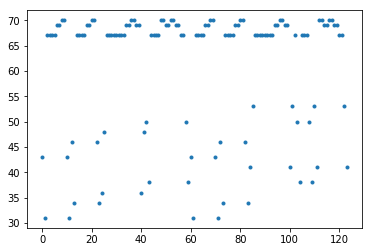

In [6]:
plt.plot(notes,'.')

In [9]:
from keras.layers import LSTM, Dense, Dropout, Flatten, TimeDistributed
from keras.layers import Input, Embedding
from keras.models import Model

In [41]:
sequence_length = 20
feature_dim=1
# get all pitch names
pitchnames = sorted(set(item for item in notes))
n_catagory=len(pitchnames)
print (n_catagory)
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in =  notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
print (n_patterns)
# reshape the input into a format compatible with LSTM layers
network_input = numpy.reshape(network_input, (n_patterns, sequence_length,feature_dim))
network_output = keras.utils.to_categorical(network_output,num_classes=n_catagory)
print (network_output.shape)

13
104
(104, 13)


In [69]:
main_input = Input(shape=(sequence_length,feature_dim), name='main_input')
#x = Embedding(output_dim=512, input_dim=(n_catagory,2), input_length=100)(main_input)
lstm_out1 = LSTM(128,return_sequences=True)(main_input)
lstm_out2 = LSTM(64)(lstm_out1)
main_output = Dense(13, activation='softmax', name='main_output')(lstm_out2)
model = Model(inputs=[main_input], outputs=[main_output])
model.compile(optimizer='rmsprop',\
              loss={'main_output': 'binary_crossentropy'},\
              loss_weights={'main_output': 1.})

# And trained it via:
model.fit({'main_input': network_input},\
          {'main_output': network_output},\
          epochs=200, batch_size=32)

Epoch 1/200
104/104 [==============================] - 1s 13ms/step - loss: 0.2545
Epoch 2/200
104/104 [==============================] - 0s 1ms/step - loss: 0.2271
Epoch 3/200
104/104 [==============================] - 0s 1ms/step - loss: 0.2233
Epoch 4/200
104/104 [==============================] - 0s 1ms/step - loss: 0.2218
Epoch 5/200
104/104 [==============================] - 0s 1ms/step - loss: 0.2200A: 0s - loss: 0.213
Epoch 6/200
104/104 [==============================] - 0s 1ms/step - loss: 0.2212
Epoch 7/200
104/104 [==============================] - 0s 1ms/step - loss: 0.2177
Epoch 8/200
104/104 [==============================] - 0s 1ms/step - loss: 0.2194
Epoch 9/200
104/104 [==============================] - 0s 1ms/step - loss: 0.2142
Epoch 10/200
104/104 [==============================] - 0s 1ms/step - loss: 0.2131A: 0s - loss: 0.217
Epoch 11/200
104/104 [==============================] - 0s 1ms/step - loss: 0.2107
Epoch 12/200
104/104 [==============================] - 0

104/104 [==============================] - 0s 1ms/step - loss: 0.0332
Epoch 197/200
104/104 [==============================] - 0s 1ms/step - loss: 0.0436
Epoch 198/200
104/104 [==============================] - 0s 1ms/step - loss: 0.0404
Epoch 199/200
104/104 [==============================] - 0s 1ms/step - loss: 0.0301
Epoch 200/200
104/104 [==============================] - 0s 1ms/step - loss: 0.0383


In [12]:
!ls featureToMidi

testing.mid


In [70]:
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
prediction = model.predict(network_input, verbose=0)
print (numpy.argmax(prediction,axis=1))
print ()
predict_note= [int_to_note[index] for index in numpy.argmax(prediction,axis=1)]

[12 12 12  1  1  1 10 10 10 10 10 10 10 10 11 11 11 12 12 11  2  7  8  3
 10 10 10 10 12 12 11 11 12 12 12 11 10 10  8  3  5  0 10 10 10 10 11 11
 12 12  6  6  6  1 10 10 10 10 11 11 12 12 12  1  1  1 10 10 10 10 10 10
 10 10 11 11 11 12 11 11  4  9 10  8  3 10 10 10  8  3  9  4 12 12 11 11
 12 12 11 11 10 10  9  9]



In [71]:
print (notes[sequence_length:])
accurcy=np.sum([1 if x==y else 0 for x,y in zip(predict_note,notes[sequence_length:])])/len(predict_note)
print (accurcy)

[70, 70, 46, 34, 36, 48, 67, 67, 67, 67, 67, 67, 67, 67, 69, 69, 70, 70, 69, 69, 36, 48, 50, 38, 67, 67, 67, 67, 70, 70, 69, 69, 70, 70, 69, 69, 67, 67, 50, 38, 43, 31, 67, 67, 67, 67, 69, 69, 70, 70, 43, 31, 46, 34, 67, 67, 67, 67, 69, 69, 70, 70, 46, 34, 41, 53, 67, 67, 67, 67, 67, 67, 67, 67, 69, 69, 70, 70, 69, 69, 41, 53, 67, 50, 38, 67, 67, 67, 50, 38, 53, 41, 70, 70, 69, 69, 70, 70, 69, 69, 67, 67, 53, 41]
0.875


In [13]:
!open featureToMidi

In [72]:
import os
import mido
import numpy as np
from mido import Message, MidiFile, MidiTrack
import pickle
import sys

MAX_NUM_FILES = 20
MIN_NUM_MESSAGES_PER_FILE = 100

''' 
Returns array of song features.  Goes through first MAX_NUM_FILES in data directory
Periodically saves the data to features.pickle
'''
def getAllFeatureVectors():
    rootdir = os.getcwd() + '/data/'
    
    featureVectors = []
    i = 0
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            #print i
            if (i >= MAX_NUM_FILES):
                break
            
            midiFileName = os.path.join(subdir, file)
            #sys.stdout.write(midiFileName)
            
            #if ("beatle" not in midiFileName.lower()):
            #    continue
            if (not midiFileName.endswith('.mid')):
                continue
            #featureVector = getFeatureVector(midiFileName)
            try:
                featureVector = getFeatureVector(midiFileName)
                #print 'len',len(featureVector)
                if (len(featureVector) >= MIN_NUM_MESSAGES_PER_FILE):
                    #print 'file number: ', os.path.getsize(midiFileName), i, file
                    featureVectors.append(featureVector)
                else:
                    
                    i += -1
            except:
                #print('exception')
                i += -1
            i+=1
                
            #save the data every so often 
            if (i %1000 == 0):
                pickling_on = open("features.pickle","wb")
                pickle.dump(np.array(featureVectors), pickling_on)
                pickling_on.close()
        if (i >= MAX_NUM_FILES):
            break
           
   # Convert to numpy arrays
    return np.array(featureVectors)


def getFeatureVector(midiFileName):
    file = MidiFile(midiFileName)
    
    #Get All the messages
    messages = []
    for message in file:#TODO: TRACKS???
        if message.type in ['note_on','note_off']:
            messages.append(message)
    
    features = []
    note = None
    duration = None
    timeSincePreviousNote = 0.0
    
    i = 0
    for message in messages:
        try:
            timeSincePreviousNote += message.time #TODO: DETERMINE IF THIS IS IN TICKS, IF SO , CHANGE TO SECONDS OR MAYBE NOT. IDK
        except:
            j = 4
            
        #determine if the message is the start of the note
        if (message.type not in ['note_on']):
            continue
        #don't use the percussion channel
        if (message.channel >9):
            continue
        note = message.note
        
        #Find out when the note is finished playing to calculate duration
        '''duration = 0.0
        for futureMessage in messages[i:]:
            if (type(futureMessage.time) is float or type(futureMessage.time) is int):
                duration += float(futureMessage.time)
            if futureMessage.type in ['note_off']:
                if futureMessage.note == note:
                    break
        '''
        #newFeatureVector = [note, velocity, duration, timeSincePreviousNote, message.channel]
        #noteVect = np.zeros(128)
        #noteVect[note] = 1
        
        newFeatureVector = [note, timeSincePreviousNote, message.velocity]
        features.append(newFeatureVector)
        
        timeSincePreviousNote = 0.0
        i += 1
       
    return np.array(features)
   
featureVectors = getAllFeatureVectors()

#print featureVectors[0]

pickling_on = open("beatles_features.pickle","wb")
pickle.dump(featureVectors, pickling_on)
pickling_on.close()

In [335]:
features = np.concatenate(getAllFeatureVectors())
print (features[0])
notes=np.hsplit(features,3)[0].ravel()
pitchnames = sorted(set(item for item in notes))
print (pitchnames)

[ 41.   0. 100.]
[28.0, 29.0, 30.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0]


In [392]:
n_catagory=len(pitchnames)
print (n_catagory)
features = getAllFeatureVectors()
print (len(features))
sequence_length = 12
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
print (note_to_int)
notestotal=[]
notes_input = []
notes_output = []
notes_comp=[]
other_input = []
for i in range(len(features)):
    notes=np.hsplit(features[i],3)[0].ravel()
    times=np.hsplit(features[i],3)[1].ravel()
    #velocitys=np.hsplit(features[i],3)[2].ravel()
    for j in range(0, len(notes) - sequence_length, 1):
        sequence_in =  notes[j:j + sequence_length]
        sequence_out = notes[j + sequence_length]
        notes_input.append([note_to_int[char] for char in sequence_in])
        notes_output.append(note_to_int[sequence_out])
        notes_comp.append(note_to_int[sequence_out])
        other_input.append(times[j])
n_patterns = len(notes_input)
print (n_patterns)
# reshape the input into a format compatible with LSTM layers
notes_input = numpy.reshape(notes_input, (n_patterns, sequence_length, 1))
notes_output = keras.utils.to_categorical(notes_output,num_classes=n_catagory)
notes_comp=np.array(notes_comp)
other_input = numpy.reshape(other_input, (n_patterns, 1))
print (notes_input.shape)
print (other_input[100:110])

63
20
{28.0: 0, 29.0: 1, 30.0: 2, 32.0: 3, 33.0: 4, 34.0: 5, 35.0: 6, 36.0: 7, 37.0: 8, 38.0: 9, 39.0: 10, 40.0: 11, 41.0: 12, 42.0: 13, 43.0: 14, 44.0: 15, 45.0: 16, 46.0: 17, 47.0: 18, 48.0: 19, 49.0: 20, 50.0: 21, 51.0: 22, 52.0: 23, 53.0: 24, 54.0: 25, 55.0: 26, 56.0: 27, 57.0: 28, 58.0: 29, 59.0: 30, 60.0: 31, 61.0: 32, 62.0: 33, 63.0: 34, 64.0: 35, 65.0: 36, 66.0: 37, 67.0: 38, 68.0: 39, 69.0: 40, 70.0: 41, 71.0: 42, 72.0: 43, 73.0: 44, 74.0: 45, 75.0: 46, 76.0: 47, 77.0: 48, 78.0: 49, 79.0: 50, 80.0: 51, 81.0: 52, 82.0: 53, 83.0: 54, 84.0: 55, 85.0: 56, 86.0: 57, 87.0: 58, 88.0: 59, 89.0: 60, 90.0: 61, 91.0: 62}
5212
(5212, 12, 1)
[[0.326087 ]
 [0.1630435]
 [0.       ]
 [0.326087 ]
 [0.       ]
 [0.1630435]
 [0.       ]
 [0.       ]
 [0.652174 ]
 [0.326087 ]]


In [397]:
main_input = Input(shape=(sequence_length,1), name='main_input')
#aux_input = Input(shape=(1,), name='aux_input')
#x = Embedding(output_dim=512, input_dim=(n_catagory,2), input_length=100)(main_input)
lstm_out1 = LSTM(64,return_sequences=True)(main_input)
lstm_out2 = LSTM(32)(lstm_out1)
main_output = Dense(n_catagory, activation='softmax', name='main_output')(lstm_out2)
#x = keras.layers.concatenate([main_output, aux_input])
x = Dense(32, activation='relu')(main_output)
x = Dense(32, activation='relu')(x)
aux_output = Dense(1, activation='sigmoid', name='aux_output')(x)
model = Model(inputs=[main_input], outputs=[main_output,aux_output])
model.compile(optimizer='rmsprop',\
              loss={'main_output': 'categorical_crossentropy', 'aux_output': 'mean_squared_error'},\
              loss_weights={'main_output': 1., 'aux_output': 0.2})

# And trained it via:

model.fit({'main_input': notes_input},\
          {'main_output': notes_output, 'aux_output': other_input},\
          epochs=100, batch_size=32)

Epoch 1/100
5212/5212 [==============================] - 8s 1ms/step - loss: 3.4957 - main_output_loss: 3.4715 - aux_output_loss: 0.1207
Epoch 2/100
5212/5212 [==============================] - 3s 549us/step - loss: 3.2354 - main_output_loss: 3.2154 - aux_output_loss: 0.0999
Epoch 3/100
5212/5212 [==============================] - 3s 558us/step - loss: 3.0884 - main_output_loss: 3.0684 - aux_output_loss: 0.0996
Epoch 4/100
5212/5212 [==============================] - 3s 565us/step - loss: 2.9724 - main_output_loss: 2.9525 - aux_output_loss: 0.0993
Epoch 5/100
5212/5212 [==============================] - 3s 560us/step - loss: 2.8814 - main_output_loss: 2.8616 - aux_output_loss: 0.0991
Epoch 6/100
5212/5212 [==============================] - 3s 563us/step - loss: 2.8135 - main_output_loss: 2.7938 - aux_output_loss: 0.0988
Epoch 7/100
5212/5212 [==============================] - 3s 576us/step - loss: 2.7474 - main_output_loss: 2.7277 - aux_output_loss: 0.0987
Epoch 8/100
5212/5212 [======

5212/5212 [==============================] - 3s 585us/step - loss: 1.4022 - main_output_loss: 1.3832 - aux_output_loss: 0.0948
Epoch 60/100
5212/5212 [==============================] - 3s 584us/step - loss: 1.3831 - main_output_loss: 1.3641 - aux_output_loss: 0.0950
Epoch 61/100
5212/5212 [==============================] - 3s 573us/step - loss: 1.3652 - main_output_loss: 1.3462 - aux_output_loss: 0.0951
Epoch 62/100
5212/5212 [==============================] - 3s 586us/step - loss: 1.3536 - main_output_loss: 1.3346 - aux_output_loss: 0.0950
Epoch 63/100
5212/5212 [==============================] - 3s 569us/step - loss: 1.3322 - main_output_loss: 1.3133 - aux_output_loss: 0.0949
Epoch 64/100
5212/5212 [==============================] - 3s 585us/step - loss: 1.3222 - main_output_loss: 1.3032 - aux_output_loss: 0.0950
Epoch 65/100
5212/5212 [==============================] - 3s 579us/step - loss: 1.3025 - main_output_loss: 1.2835 - aux_output_loss: 0.0949
Epoch 66/100
5212/5212 [=========

In [398]:
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
prediction1,prediction2 = model.predict({'main_input': notes_input})
print (prediction1.shape)
print (prediction2[:10])
#print (numpy.argmax(prediction,axis=1))
#print ()
print (max(notes_comp))
predict_note= [int_to_note[int(index)] for index in numpy.argmax(prediction1,axis=1)]
notes_true=[int_to_note[int(index)] for index in notes_comp]
accurcy=np.sum([1 if x==y else 0 for x,y in zip(predict_note,notes_true)])/len(predict_note)
print (accurcy)

(5212, 63)
[[0.13775192]
 [0.1873982 ]
 [0.13846077]
 [0.19238305]
 [0.26770246]
 [0.09019112]
 [0.0312456 ]
 [0.06561729]
 [0.17091355]
 [0.15939069]]
62
0.7603607060629317


In [101]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [116]:
features = np.concatenate(getAllFeatureVectors())
features = scaler.fit_transform(features)
features.shape

(5452, 3)

In [303]:
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return numpy.array(dataX), numpy.array(dataY)
look_back = 6
X, Y = create_dataset(features,look_back)
X_train=X[:2000]
Y_train=Y[:2000]
X_test=X[2000:4000]
Y_test=Y[2000:4000]
X_train.shape,Y_train.shape

((2000, 6, 3), (2000, 3))

In [304]:
model = keras.Sequential()
model.add(LSTM(64, input_shape=(look_back, 3)))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(3, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='sgd')

In [306]:
model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
2000/2000 [==============================] - 0s 216us/step - loss: 0.9526
Epoch 2/100
2000/2000 [==============================] - 0s 192us/step - loss: 0.9472
Epoch 3/100
2000/2000 [==============================] - 0s 192us/step - loss: 0.9412
Epoch 4/100
2000/2000 [==============================] - 0s 194us/step - loss: 0.9343
Epoch 5/100
2000/2000 [==============================] - 0s 194us/step - loss: 0.9265
Epoch 6/100
2000/2000 [==============================] - 0s 195us/step - loss: 0.9178
Epoch 7/100
2000/2000 [==============================] - 0s 192us/step - loss: 0.9078
Epoch 8/100
2000/2000 [==============================] - 0s 194us/step - loss: 0.8965
Epoch 9/100
2000/2000 [==============================] - 0s 195us/step - loss: 0.8835
Epoch 10/100
2000/2000 [==============================] - 0s 195us/step - loss: 0.8694
Epoch 11/100
2000/2000 [==============================] - 0s 197us/step - loss: 0.8540
Epoch 12/100
2000/2000 [============================

In [402]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [307]:
Y_predict = model.predict(X_test)

In [308]:
(Y_predict-Y_test).shape

(2000, 3)

In [309]:
test_loss=np.sum([np.dot(y_delta,y_delta) for y_delta in (Y_predict-Y_test)])/(Y_predict-Y_test).shape[0]/3
print (test_loss)

1.063026936295108


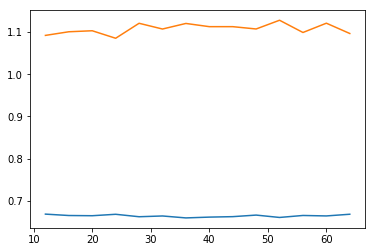

In [400]:
#epoch=100
n_neuron_onelayer=[12,16,20,24,28,32,36,40,44,48,52,56,60,64]
train_loss_onelayer=[0.6684,0.6651,0.6646,0.6680,0.6622,0.6640,0.6594,0.6613,0.6624,0.6661,0.6605,\
            0.6652,0.6641,0.6681]
test_loss_onelayer=[1.0919,1.1005,1.1029,1.0851,1.1206,1.1070,1.1202,1.1126,1.1126,1.1071,1.1278,\
          1.0988,1.1208,1.0964]
plt.plot(n_neuron_onelayer,train_loss_onelayer)
plt.plot(n_neuron_onelayer,test_loss_onelayer)

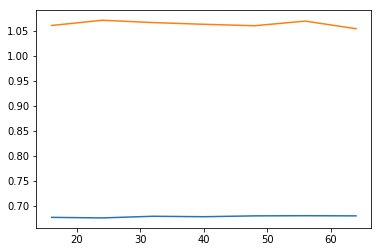

In [401]:
#epoch=100
n_neuron_twolayer=[16,24,32,40,48,56,64]
train_loss_twolayer=[0.6767,0.6756,0.6789,0.6780,0.6797,0.6800,0.6797]
test_loss_twolayer=[1.0612,1.0717,1.0670,1.0636,1.0607,1.0700,1.0547]
plt.plot(n_neuron_twolayer,train_loss_twolayer)
plt.plot(n_neuron_twolayer,test_loss_twolayer)

In [23]:
import seaborn as sns
sns.set_style('darkgrid')

In [68]:
Y_hat

array([[ 0.7166391 , -0.12023745, -0.03724909],
       [ 0.7168887 ,  0.05233854,  0.08632386],
       [ 0.72470576,  0.08964669,  0.14873257],
       ...,
       [-0.34180415, -0.3976169 , -0.18748423],
       [-0.360519  ,  0.36732563, -0.5765101 ],
       [-0.22899117,  0.81024516, -0.4173819 ]], dtype=float32)

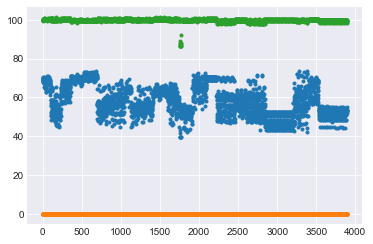

In [69]:
plt.plot(scaler.inverse_transform(Y_hat),'.')

In [70]:
scaler.inverse_transform(Y_hat)

array([[6.9030693e+01, 9.6764714e-02, 9.9690567e+01],
       [6.9034355e+01, 1.2288289e-01, 9.9964554e+01],
       [6.9149033e+01, 1.2852922e-01, 1.0010293e+02],
       ...,
       [5.3502922e+01, 5.4785270e-02, 9.9357468e+01],
       [5.3228367e+01, 1.7055398e-01, 9.8494926e+01],
       [5.5157932e+01, 2.3758677e-01, 9.8847740e+01]], dtype=float32)

In [32]:
from mido import Message, MidiFile, MidiTrack

#turn the feature vector back into a MIDI file
def featuresToMidi(features, fileName):
    directory = "featureToMidi"
    mid = MidiFile(type=0)
    track = MidiTrack()
    mid.tracks.append(track)
    
    #track.append(Message('program_change', program=12, time=0))
    
    withTimeFromStart = []
    timeFromStart = 0
    
    for feature in features:
        note = feature[0]
        
        deltaTime = feature[1]
        timeFromStart += deltaTime
        
        velocity = feature[2]
        
        withTimeFromStart.append(np.array(['note_on', note, deltaTime, velocity, timeFromStart]))
        #withTimeFromStart.append(np.array(['note_off', note, velocity, duration, timeFromStart+duration]))
        
    withTimeFromStart = np.array(withTimeFromStart)
    
    #sortedIndicies = withTimeFromStart[:,4].sort(axis=0)
    #withTimeFromStart = withTimeFromStart[sortedIndicies][0]
       
    currTime = 0.0
    for m in withTimeFromStart:
        prevTime = currTime
    
        currTime = float(m[4])
        
        n = int(round(float(m[1])))
        
        t = currTime - prevTime
        #TIME IS STORED IN TICKS NOT SECONDS.  SO IM GONNA JUST GUESS HERE
        tempo = mido.bpm2tempo(128)
        t = mido.second2tick(t, 500 , tempo)#second, ticks_per_beat, tempo)
        #print currTime, t, m[0]
        track.append(Message(type=m[0], note=n, velocity=int(round(float(m[3]))), channel=4, time=abs(int(round(t)))))
    
    cwd = os.getcwd()
    rootdir = (cwd + '/' + directory + '/')
    mid.save(directory + "/" + fileName)
    
    '''port = mido.open_output()
    #port.send(msg)
    for msg in MidiFile(directory + "/" + fileName).play():
        port.send(msg)'''

i = 0
for f in featureVectors:
    #print(i)
    featuresToMidi(f, 'beatles'+str(i)+'.mid')
    i+=1
#featuresToMidi(featureVectors[44], 'testing.mid')

IndexError: index 2 is out of bounds for axis 0 with size 2

### Functional form of loss function:

In [171]:
x = np.linspace(-48,47,96)

In [88]:
x

array([-48., -47., -46., -45., -44., -43., -42., -41., -40., -39., -38.,
       -37., -36., -35., -34., -33., -32., -31., -30., -29., -28., -27.,
       -26., -25., -24., -23., -22., -21., -20., -19., -18., -17., -16.,
       -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,
        -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,
         7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,
        18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,
        29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,
        40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.])

In [5]:
def loss_func(y_true, y_pred):
    import scipy
    x = np.linspace(-48,47,96)
    y = np.array([0.8, 1.8, 1.8, 1.8, 1. , 1.8, 1.8, 1. , 1.8, 1.8, 1.8, 1.8, 0.6,
       1.6, 1.6, 1.6, 0.8, 1.6, 1.6, 0.8, 1.6, 1.6, 1.6, 1.6, 0.4, 1.4,
       1.4, 1.4, 0.6, 1.4, 1.4, 0.6, 1.4, 1.4, 1.4, 1.4, 0.2, 1.2, 1.2,
       1.2, 0.4, 1.2, 1.2, 0.4, 1.2, 1.2, 1.2, 1.2, 0. , 1. , 1. , 1. ,
       0.2, 1. , 1. , 0.2, 1. , 1. , 1. , 1. , 0.2, 1.2, 1.2, 1.2, 0.4,
       1.2, 1.2, 0.4, 1.2, 1.2, 1.2, 1.2, 0.4, 1.4, 1.4, 1.4, 0.6, 1.4,
       1.4, 0.6, 1.4, 1.4, 1.4, 1.4, 0.6, 1.6, 1.6, 1.6, 0.8, 1.6, 1.6,
       0.8, 1.6, 1.6, 1.6, 1.6])
    x = x[24:72]
    y = y[24:72]
    # fit = scipy.poly1d(scipy.polyfit(x,y,deg=40))
    delta1 = y_true[0][0]-y_pred[0][0]
    loss1 = scipy.poly1d(scipy.polyfit(x,y,deg=40))(delta1)
    loss2 = (y_true[1]-y_pred[1])**2
    loss3 = (y_true[2]-y_pred[2])**2
    return loss1+loss2+loss3

In [111]:
y = [[0,1,1,1,0.2,1,1,0.2,1,1,1,1]]*8

In [112]:
y = np.array(y)

In [120]:
y[8] = y[8]+0.8

IndexError: index 8 is out of bounds for axis 0 with size 8

In [172]:
y = np.array([0.8, 1.8, 1.8, 1.8, 1. , 1.8, 1.8, 1. , 1.8, 1.8, 1.8, 1.8, 0.6,
       1.6, 1.6, 1.6, 0.8, 1.6, 1.6, 0.8, 1.6, 1.6, 1.6, 1.6, 0.4, 1.4,
       1.4, 1.4, 0.6, 1.4, 1.4, 0.6, 1.4, 1.4, 1.4, 1.4, 0.2, 1.2, 1.2,
       1.2, 0.4, 1.2, 1.2, 0.4, 1.2, 1.2, 1.2, 1.2, 0. , 1. , 1. , 1. ,
       0.2, 1. , 1. , 0.2, 1. , 1. , 1. , 1. , 0.2, 1.2, 1.2, 1.2, 0.4,
       1.2, 1.2, 0.4, 1.2, 1.2, 1.2, 1.2, 0.4, 1.4, 1.4, 1.4, 0.6, 1.4,
       1.4, 0.6, 1.4, 1.4, 1.4, 1.4, 0.6, 1.6, 1.6, 1.6, 0.8, 1.6, 1.6,
       0.8, 1.6, 1.6, 1.6, 1.6])

In [128]:
import scipy

In [189]:
fit = scipy.poly1d(scipy.polyfit(x,y,deg=40))

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


In [175]:
x = x[24:72]
y = y[24:72]

In [187]:
xp = np.linspace(-10,10,1000)

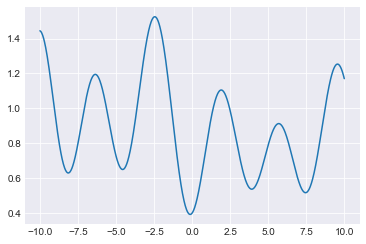

In [190]:
plt.plot(xp,fit(xp))#,x,y,'.')

In [162]:
scipy.polyfit(x,y,deg=40)

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


array([-2.37821556e-57, -4.88059435e-56,  4.18184535e-53,  8.17973927e-52,
       -3.23507804e-49, -5.96747024e-48,  1.41516494e-45,  2.40677790e-44,
       -3.62046723e-42, -5.29968072e-41,  4.15538261e-39,  2.83200124e-38,
        5.75891923e-36,  2.10335370e-34, -3.59151421e-32, -7.99291860e-31,
        8.22885198e-29,  1.59910773e-27, -1.20350301e-25, -2.15605656e-24,
        1.24214248e-22,  2.08957813e-21, -9.32556207e-20, -1.48607541e-18,
        5.11605322e-17,  7.76689664e-16, -2.02847724e-14, -2.95038178e-13,
        5.66851488e-12,  7.96737481e-11, -1.07012476e-09, -1.47823780e-08,
        1.27565612e-07,  1.79480566e-06, -8.63225570e-06, -1.33005009e-04,
        2.84517737e-04,  5.37000240e-03, -3.40385544e-03, -9.69933140e-02,
        8.80846020e-01])

In [199]:
scaler2.fit_transform([x])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [200]:
y

array([0.4, 1.4, 1.4, 1.4, 0.6, 1.4, 1.4, 0.6, 1.4, 1.4, 1.4, 1.4, 0.2,
       1.2, 1.2, 1.2, 0.4, 1.2, 1.2, 0.4, 1.2, 1.2, 1.2, 1.2, 0. , 1. ,
       1. , 1. , 0.2, 1. , 1. , 0.2, 1. , 1. , 1. , 1. , 0.2, 1.2, 1.2,
       1.2, 0.4, 1.2, 1.2, 0.4, 1.2, 1.2, 1.2, 1.2])

In [197]:
scaler2 = StandardScaler()

In [218]:
fit(-6)

1.1421802099804372